In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from bnr_ml.nnet import layers
from bnr_ml.objectdetect import yolo
from bnr_ml.nnet.updates import momentum
import theano
from theano import tensor as T
from collections import OrderedDict
from tqdm import tqdm

import pdb

In [3]:
def gen_num_objs(max_obj):
    return int(1 + max_obj * np.random.rand())

In [4]:
def gen_classes(num_obj, num_class):
    return np.random.randint(num_class, size=(num_obj,))

In [5]:
def gen_circle(shape):
#     pdb.set_trace()
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = (row - row.shape[1] / 2) / (row.shape[1] / 2)
    col = (col - col.shape[0] / 2) / (col.shape[0] / 2)
    
    
    im = np.zeros(shape + (1,))
    for i in range(im.shape[2]):
        in_ellipse = (row**2 + col**2) < 1
        im[:,:,i][in_ellipse] = np.ones(shape)[in_ellipse]
#         im[:,:,i][in_ellipse] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_ellipse]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [6]:
def gen_rect(shape):
    im = np.zeros(shape + (3,))
    for i in range(3):
        im[:,:,i] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))
    im[im < 0] = 0.
    im[im > 1] = 1.
    return im

In [7]:
def gen_triangle(shape):
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = row / row.shape[1]
    col = col / col.shape[0]
    
    
    im = np.zeros(shape + (1,))
    if np.random.rand() < .5:
        in_triangle = row + col < 1
    else:
        in_triangle = row + col > 1
    for i in range(im.shape[2]):
#         im[:,:,i][in_triangle] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_triangle]
        im[:,:,i][in_triangle] = np.ones(shape)[in_triangle]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [8]:
def gen_pos_shape(min_shape, im_shape):
    shape = (
        int(min_shape[0] + (im_shape[0] - min_shape[0]) * np.random.rand()),
        int(min_shape[1] + (im_shape[1] - min_shape[1]) * np.random.rand())
    )
    pos = (
        int((im_shape[0] - shape[0]) * np.random.rand()),
        int((im_shape[1] - shape[1]) * np.random.rand())
    )
    return shape, pos

In [9]:
def gen_scene(max_obj, num_class, min_shape, im_shape):
    num_obj = gen_num_objs(max_obj)
    classes = gen_classes(num_obj, num_class)
#     im = np.random.gamma(.2) * np.random.randn(*(im_shape + (3,)))
    im = np.zeros(im_shape + (1,))
    im[im < 0] = 0.
    im[im > 1] = 1.
    y = np.zeros((4 + num_class,))
    
    for cls in classes:
        shape, pos = gen_pos_shape(min_shape, im_shape)
        y[:4] = pos + shape
        y[-num_class + cls] += 1.
        if cls == 0:
            shp = gen_circle(shape)
        elif cls == 1:
            shp = gen_triangle(shape)
        elif cls == 2:
            shp = gen_triangle(shape)
        else:
            pass
        im[pos[0]:pos[0]+shape[0],pos[1]:pos[1]+shape[1],:] += shp
    return im / np.max(im), y

In [10]:
def gen_dataset(size, shape):
    X, y = np.zeros((size,1) + shape), np.zeros((size,4+2))
    for i in range(size):
        dat = gen_scene(1, 2, (25,25), shape)
        X[i], y[i] = dat[0].swapaxes(2,1).swapaxes(1,0), dat[1]
    return X, y

In [11]:
X,y = gen_dataset(10000, (100,100))

In [ ]:
N = np.int_(X.shape[0] * np.random.rand())
plt.imshow(X[N,0], 'gray')
plt.show()

In [85]:
input = T.tensor4('input')

In [86]:
l1 = layers.ConvolutionalLayer2D(
    (None,1,100,100),
    (3,3),
    16,
    input=input
)
l2 = layers.ConvolutionalLayer2D(
    l1.get_output_shape(),
    (3,3),
    16,
    input=layers.NonLinLayer(T.nnet.relu, input=l1.output).output
)
l3 = layers.PoolLayer2D(
    l2.get_output_shape(),
    (3,3),
    input=layers.NonLinLayer(T.nnet.relu, input=l2.output).output
)
l4 = layers.ConvolutionalLayer2D(
    l3.get_output_shape(),
    (3,3),
    16,
    input=l3.output
)
l5 = layers.ConvolutionalLayer2D(
    l4.get_output_shape(),
    (3,3),
    16,
    input=layers.NonLinLayer(T.nnet.relu, input=l4.output).output
)
l6 = layers.PoolLayer2D(
    l5.get_output_shape(),
    (3,3),
    input=layers.NonLinLayer(T.nnet.relu, input=l5.output).output
)

l7 = layers.FCLayer(
    l6.get_output_shape(),
    1024,
    input=l6.output
)
l8 = layers.FCLayer(
    l7.get_output_shape(),
    2,
    input=layers.NonLinLayer(T.nnet.relu, input=l7.output).output
)
# l9 = layers.FCLayer(
#     l8.get_output_shape(),
#     2,
#     input=l8.output
# )

params = []
params.extend(l1.get_params())
params.extend(l2.get_params())
params.extend(l3.get_params())
params.extend(l4.get_params())
params.extend(l5.get_params())
params.extend(l6.get_params())
params.extend(l7.get_params())
params.extend(l8.get_params())
# params.extend(l9.get_params())

label = T.nnet.softmax(l8.output)

In [67]:
fun = theano.function([input], l6.output)

In [68]:
tmp = fun(X[:40])

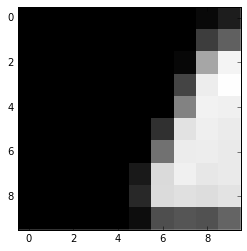

[ 0.  1.]


In [84]:
N = np.int_(tmp.shape[0] * np.random.rand())
plt.imshow(tmp[N,0], 'gray', interpolation='none')
plt.show()
print y[N,-2:]

In [87]:
# l1.W.set_value(weights[0]['W'])
# l1.b.set_value(weights[0]['b'])

# l3.W.set_value(weights[1]['W'])
# l3.b.set_value(weights[1]['b'])

# # l7.W.set_value(weights[1]['W'])
# # l7.b.set_value(weights[1]['b'])

# # l8.W.set_value(weights[2]['W'])
# # l8.b.set_value(weights[2]['b'])

In [ ]:
# pretrain
target = T.matrix('target')

def cross_ent(output, target):
    return - T.sum(target * T.log(output), axis=1).mean()


cost = cross_ent(label, target)

# params = layers.get_all_params(l9)

grads = T.grad(cost, params)

updates = momentum(cost, params, lr=1e-5, momentum=0.5)

train_fn = theano.function([input, target], cost, updates=updates)
test_fn = theano.function([input, target], cost)

In [ ]:
np.random.seed(1991)

N = np.int_(.9 * X.shape[0])
Xtrain, ytrain = X[:N], y[:N,-2:]
Xtest, ytest = X[N:], y[N:,-2:]

idx = np.arange(N)

epochs = 80
batch_size=50

train_cost = []
test_cost = []

for epoch in range(epochs):
    batch_cost = []
    np.random.shuffle(idx)
    Xtrain, ytrain = Xtrain[idx], ytrain[idx]
    for i in tqdm(range(0,Xtrain.shape[0],batch_size)):
        Xbatch,ybatch = Xtrain[i*batch_size:(i+1)*batch_size], ytrain[i*batch_size:(i+1)*batch_size]
        if Xbatch.shape[0] > 0:
            err =  train_fn(Xbatch, ybatch)
            batch_cost.append(err)
    train_cost.append(np.mean(batch_cost))
    test_cost.append(test_fn(Xtest,ytest))
    print('Training error: %.4f, Test eror: %.4f' % (train_cost[epoch], test_cost[epoch]))

100%|██████████| 180/180 [00:09<00:00, 18.11it/s]


Training error: 0.6931, Test eror: 0.6931


100%|██████████| 180/180 [00:10<00:00, 17.83it/s]


In [ ]:
plt.figure(figsize=(8,8))
plt.plot(train_cost, 'r')
plt.plot(test_cost, 'b')
plt.show()

In [ ]:
pred_fn = theano.function([input], label)

In [ ]:
preds = pred_fn(Xtest)

In [ ]:
N = np.int_(Xtest.shape[0] * np.random.rand())
plt.imshow(Xtest[N,0])
plt.show()

if np.argmax(preds[N]) == 0:
    print 'Circle'
else:
    print 'Triangle'
print'Confidence: %.3f' % preds[N][np.argmax(preds[N])]

In [ ]:
weights = []
weights.append({'W': np.copy(l1.W.get_value(borrow=True)), 'b': np.copy(l1.b.get_value(borrow=True))})
weights.append({'W': np.copy(l3.W.get_value(borrow=True)), 'b': np.copy(l3.b.get_value(borrow=True))})


# weights.append({'W': np.copy(l7.W.get_value(borrow=True)), 'b': np.copy(l8.b.get_value(borrow=True))})
# weights.append({'W': np.copy(l7.W.get_value(borrow=True)), 'b': np.copy(l8.b.get_value(borrow=True))})

In [ ]:
reload(layers)
reload(yolo)

In [ ]:
yl = yolo.YoloObjectDetector(net, (None,3,200,200), 3, (2,2), 2)

In [ ]:
yl.train(
    X,
    y,
    lr=1e-2
)

In [ ]:
pred_fn = theano.function([yl.input], yl.output)

In [ ]:
Xval,yval = gen_dataset(50)

In [ ]:
yval[:2]

In [ ]:
pred_fn(Xval[:2])